<a href="https://colab.research.google.com/github/nandiniparekh/ReFocus/blob/main/ML_model_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Install gdown if needed ---
!pip install gdown --quiet

# --- Imports ---
import gdown
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from sklearn.preprocessing import StandardScaler

In [ ]:
# --- Step 1: Download dataset from Google Drive ---
file_id = "1gZPZxka2PjjNqKZcoFkjRezQ1xGqE1n0"
file_name = "dataset_complied.csv"
gdown.download(f"https://drive.google.com/uc?id={file_id}", file_name, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1gZPZxka2PjjNqKZcoFkjRezQ1xGqE1n0
To: /content/dataset_complied.csv
100%|██████████| 11.2M/11.2M [00:00<00:00, 60.3MB/s]


'dataset_complied.csv'

In [ ]:
df.columns

Index(['id', 'left_eye_x_norm', 'left_eye_y_norm', 'right_eye_x_norm',
       'right_eye_y_norm', 'face_width_norm', 'gaze_pitch', 'gaze_yaw',
       'au1_innerbrow', 'au2_outerbrow', 'au4_browlower', 'is_focused'],
      dtype='object')

In [ ]:

# --- Step 2: Load dataset ---
df = pd.read_csv(file_name)


In [ ]:

# --- Step 3: Constants ---
WINDOW_SIZE = 10
FEATURES = ['left_eye_x_norm', 'left_eye_y_norm', 'right_eye_x_norm', 'right_eye_y_norm',
            'face_width_norm', 'gaze_pitch', 'gaze_yaw', 'au1_innerbrow', 'au2_outerbrow', 'au4_browlower']
TARGET = ['is_focused']

In [ ]:
# --- Step 4: Dataset class ---
class FocusDataset(Dataset):
    def __init__(self, df, window_size=10, normalize=True):
        self.X = []
        self.y = []

        for subj_id in df['id'].unique():
            df_sub = df[df['id'] == subj_id].copy()

            if normalize:
                scaler = StandardScaler()
                df_sub[FEATURES] = scaler.fit_transform(df_sub[FEATURES])

            for j in range(window_size - 1, len(df_sub)):
                window = df_sub.iloc[j - window_size + 1:j + 1]
                self.X.append(window[FEATURES].values)
                self.y.append(int(df_sub.iloc[j][TARGET].item()))

        self.X = torch.tensor(np.array(self.X), dtype=torch.float32)
        self.y = torch.tensor(np.array(self.y), dtype=torch.long)  # For CrossEntropyLoss

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
# --- Step 5: Create dataset and dataloaders ---
dataset = FocusDataset(df, window_size=WINDOW_SIZE, normalize=True)

# Split: 80% train, 15% val, 5% test
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=128)
test_loader = DataLoader(test_ds, batch_size=128)

In [ ]:

# --- Step 6: Define model ---
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=2, layer_dim=1):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Final timestep
        return out  # Shape: (batch, 2)


In [ ]:

# --- Step 7: Instantiate model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(input_dim=len(FEATURES)).to(device)


In [ ]:
# --- Step 8: Training setup ---
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
EPOCHS = 10

In [ ]:

# --- Step 9: Training loop ---
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    correct, total = 0, 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * X_batch.size(0)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

    train_loss = total_loss / total
    train_acc = correct / total

        # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0.0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item() * X_batch.size(0)
            preds = torch.argmax(outputs, dim=1)
            val_correct += (preds == y_batch).sum().item()
            val_total += y_batch.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total

    print(f"Epoch {epoch+1}/{EPOCHS} | "
      f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
      f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    # ✅ Append loss/accuracy values for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)


Epoch 1/10 | Train Loss: 0.0819, Acc: 0.9703 | Val Loss: 0.1086, Acc: 0.9637
Epoch 2/10 | Train Loss: 0.0695, Acc: 0.9754 | Val Loss: 0.0886, Acc: 0.9674
Epoch 3/10 | Train Loss: 0.0600, Acc: 0.9786 | Val Loss: 0.0882, Acc: 0.9709
Epoch 4/10 | Train Loss: 0.0518, Acc: 0.9809 | Val Loss: 0.0792, Acc: 0.9757
Epoch 5/10 | Train Loss: 0.0423, Acc: 0.9846 | Val Loss: 0.0837, Acc: 0.9732
Epoch 6/10 | Train Loss: 0.0406, Acc: 0.9851 | Val Loss: 0.0745, Acc: 0.9826
Epoch 7/10 | Train Loss: 0.0369, Acc: 0.9865 | Val Loss: 0.0611, Acc: 0.9837
Epoch 8/10 | Train Loss: 0.0309, Acc: 0.9883 | Val Loss: 0.0682, Acc: 0.9821
Epoch 9/10 | Train Loss: 0.0252, Acc: 0.9912 | Val Loss: 0.0563, Acc: 0.9846
Epoch 10/10 | Train Loss: 0.0265, Acc: 0.9910 | Val Loss: 0.0526, Acc: 0.9857


In [ ]:
df['is_focused'].value_counts(normalize=True)


,proportion
is_focused,
True,0.810456
False,0.189544


In [ ]:
sample_x, sample_y = dataset[0]
print("Sample window shape:", sample_x.shape)
print("Sample label:", sample_y)


Sample window shape: torch.Size([10, 10])
Sample label: tensor(1)


In [ ]:
print(len(train_losses), len(val_losses), len(train_accuracies), len(val_accuracies))


10 10 10 10


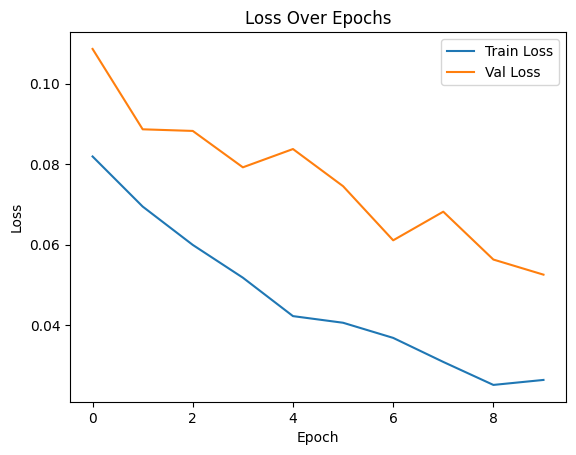

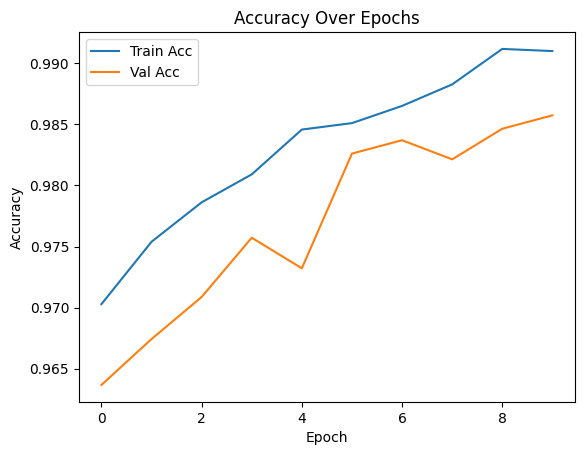

              precision    recall  f1-score   support

 Not Focused       0.94      0.98      0.96       397
     Focused       1.00      0.98      0.99      1732

    accuracy                           0.98      2129
   macro avg       0.97      0.98      0.97      2129
weighted avg       0.98      0.98      0.98      2129



In [ ]:
# --- Step 10: Evaluate on Test Set ---
from sklearn.metrics import classification_report

model.eval()
all_preds, all_labels = [], []

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

# Classification metrics
print(classification_report(all_labels, all_preds, target_names=["Not Focused", "Focused"]))


In [ ]:
# --- Step 11: Save model weights ---
torch.save(model.state_dict(), "lstm_focus_classifier.pt")


# Load later

In [ ]:
#load later
model.load_state_dict(torch.load("lstm_focus_classifier.pt"))
model.eval()


NameError: name 'model' is not defined

Handle Class Imbalance (Optional, but recommended)

In [ ]:
class_counts = df['is_focused'].value_counts().sort_index().to_numpy()
class_weights = 1.0 / torch.tensor(class_counts, dtype=torch.float32)
class_weights = class_weights / class_weights.sum()

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
